# Task 2 Multiclass classification Baseline

In this class, we will develop a baseline for Task 2 using the chess dataset. We will model the task as an multiclass classification task.

In [1]:
import matplotlib.pyplot as plt, numpy as np, os, torch, random, cv2, json
from torch import nn
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
from torchvision import models
from torchvision.transforms import v2 as transforms
from sklearn.metrics import accuracy_score
from tqdm import tqdm

random.seed(42)

### Connect Colab to Drive (if the dataset is on drive)

In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

In [3]:
#!unzip "drive/MyDrive/Dataset/images.zip" -d "."
#!cp "drive/MyDrive/Dataset/annotations.json" -d "."

## Load dataset

**Tip**: since the images are very big, resize the dataset before loading it to save time and memory during training (use cubic interpolation to preserve image quality when downsizing the images)!

In [4]:
# Normalize images
data_aug = transforms.Compose([
    transforms.ToImage(),
    transforms.Resize((256, 256)),
    transforms.CenterCrop((224, 224)),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

data_in = transforms.Compose([
    transforms.ToImage(),
    transforms.Resize((256, 256)),
    transforms.CenterCrop((224, 224)),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [5]:
def chesspos2number(chesspos):
    col = ord(chesspos[0])-ord('a')
    row = int(chesspos[1])-1
    return row, col

class ChessDataset(Dataset):
    def __init__(self, root_dir, partition, transform=None):
        self.anns = json.load(open(os.path.join(root_dir, 'annotations.json')))
        self.categories = [c['name'] for c in self.anns['categories']]
        self.root = root_dir
        self.ids = []
        self.file_names = []
        for x in self.anns['images']:
            self.file_names.append(x['path'])
            self.ids.append(x['id'])
        self.file_names = np.asarray(self.file_names)
        self.ids = np.asarray(self.ids)
        self.boards = torch.zeros((len(self.file_names), 8, 8))
        for piece in self.anns['annotations']['pieces']:
            idx = np.where(self.ids == piece['image_id'])[0][0]
            row, col = chesspos2number(piece['chessboard_position'])
            self.boards[idx][row][col] = 1

        if partition == 'train':
            self.split_ids = np.asarray(self.anns['splits']['chessred2k']['train']['image_ids']).astype(int)
        elif partition == 'valid':
            self.split_ids = np.asarray(self.anns['splits']['chessred2k']['val']['image_ids']).astype(int)
        else:
            self.split_ids = np.asarray(self.anns['splits']['chessred2k']['test']['image_ids']).astype(int)

        intersect = np.isin(self.ids, self.split_ids)
        self.split_ids = np.where(intersect)[0]
        self.file_names = self.file_names[self.split_ids]
        self.boards = self.boards[self.split_ids]
        self.num_pieces = torch.sum(self.boards.view(len(self.boards), 64), axis=-1)
        self.num_pieces = F.one_hot(self.num_pieces.long()-1, 32)
        self.ids = self.ids[self.split_ids]

        self.transform = transform
        print(f"Number of {partition} images: {len(self.file_names)}")

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, i):
        image = cv2.imread(os.path.join(self.root, self.file_names[i]))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.transform:
            image = self.transform(image)

        num_pieces = self.num_pieces[i]

        return image, num_pieces.float()

train_dataset = ChessDataset('..', 'train', data_aug)
valid_dataset = ChessDataset('..', 'valid', data_in)
test_dataset = ChessDataset('..', 'test', data_in)

Number of train images: 1442
Number of valid images: 330
Number of test images: 306


In [6]:
# get cpu or gpu device for training
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# now we need to define a Dataloader, which allows us to automatically batch our inputs, do sampling and multiprocess data loading
batch_size = 16
num_workers = 0 # how many processes are used to load the data

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, drop_last=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, drop_last=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, drop_last=False)

Using cuda device


torch.Size([16, 224, 224, 3])
torch.Size([16, 32])
tensor(23)


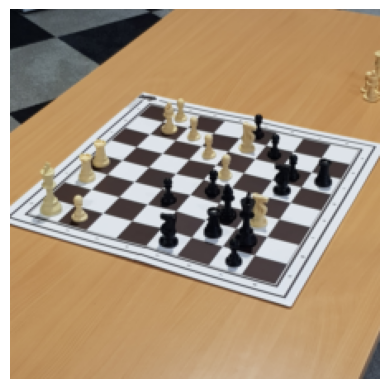

In [7]:
for batch in train_dataloader:
    # Get images of the batch and print their dimensions
    imgs = batch[0]
    imgs = imgs.permute(0, 2, 3, 1)*torch.tensor([[[0.229, 0.224, 0.225]]]) + torch.tensor([[[0.485, 0.456, 0.406]]])
    print(imgs.shape)

    # Get labels of each image in the batch and print them
    labels = batch[1]
    print(labels.shape)
    print(torch.argmax(labels[0])+1)

    # Show first image of the batch
    plt.imshow(imgs[0])
    plt.axis('off')
    plt.show()

    break

## Defining the model

We will use a pre-trained ResNet50 network.

In [8]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# Define model
weights = models.ResNet50_Weights.IMAGENET1K_V2
model = models.resnet50(weights=weights)
transforms = weights.transforms()

# change the number of neurons in the last layer to the number of classes of the problem at hand (maximum number of pieces on a chess game)
# TODO
model.fc = nn.Linear(model.fc.in_features, 32)

model.to(device)

Using cuda device


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## Train the model

Define function to perform one iteration

In [9]:
from sklearn.metrics import mean_absolute_error
def epoch_iter(dataloader, model, loss_fn, optimizer=None, is_train=True):
    if is_train:
      assert optimizer is not None, "When training, please provide an optimizer."
      
    num_batches = len(dataloader)

    if is_train:
      model.train() # put model in train mode
    else:
      model.eval()

    total_loss = 0.0
    preds = []
    labels = []

    with torch.set_grad_enabled(is_train):
      for batch, (X, y) in enumerate(tqdm(dataloader)):
          X, y = X.to(device), y.to(device)

          # Compute prediction error
          pred = model(X)
          loss = loss_fn(pred, y)

          if is_train:
            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

          # Save training metrics
          total_loss += loss.item() # IMPORTANT: call .item() to obtain the value of the loss WITHOUT the computational graph attached

          probs = F.softmax(pred, dim=1)
          final_pred = torch.argmax(probs, dim=1)
          preds.extend(final_pred.cpu().numpy())
          #print(final_pred.cpu().numpy())
          original_values =y.cpu().argmax(dim=-1) + 1
          labels.extend(original_values)
          #print(original_values)
    return total_loss / num_batches, mean_absolute_error(preds, labels)

Define function to train a model

In [10]:
def train(model, model_name, num_epochs, train_dataloader, validation_dataloader, loss_fn, optimizer):
  train_history = {'loss': [], 'accuracy': []}
  val_history = {'loss': [], 'accuracy': []}
  best_val_loss = np.inf
  print("Start training...")
  for t in range(num_epochs):
      print(f"\nEpoch {t+1}")
      train_loss, train_acc = epoch_iter(train_dataloader, model, loss_fn, optimizer)
      print(f"Train loss: {train_loss:.3f} \t Train acc: {train_acc:.3f}")
      val_loss, val_acc = epoch_iter(validation_dataloader, model, loss_fn, is_train=False)
      print(f"Val loss: {val_loss:.3f} \t Val acc: {val_acc:.3f}")

      # save model when val loss improves
      if val_loss < best_val_loss:
        best_val_loss = val_loss
        save_dict = {'model': model.state_dict(), 'optimizer': optimizer.state_dict(), 'epoch': t}
        torch.save(save_dict, model_name + '_best_model.pth')

      # save latest model
      save_dict = {'model': model.state_dict(), 'optimizer': optimizer.state_dict(), 'epoch': t}
      torch.save(save_dict, model_name + '_latest_model.pth')

      # save training history for plotting purposes
      train_history["loss"].append(train_loss)
      train_history["accuracy"].append(train_acc)

      val_history["loss"].append(val_loss)
      val_history["accuracy"].append(val_acc)
      
  print("Finished")
  return train_history, val_history

Define loss, optimizer and train the model

In [11]:
# Define loss function
loss_fn = nn.MSELoss()
# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 50

# TODO - Train the model
train_history, val_history = train(model, 'chess_model', num_epochs, train_dataloader, valid_dataloader, loss_fn, optimizer)

Start training...

Epoch 1


100%|██████████| 90/90 [03:37<00:00,  2.42s/it]


Train loss: 0.030 	 Train acc: 6.155


100%|██████████| 21/21 [00:48<00:00,  2.30s/it]


Val loss: 0.030 	 Val acc: 4.242

Epoch 2


100%|██████████| 90/90 [03:36<00:00,  2.41s/it]


Train loss: 0.023 	 Train acc: 2.495


100%|██████████| 21/21 [00:48<00:00,  2.29s/it]


Val loss: 0.031 	 Val acc: 3.227

Epoch 3


100%|██████████| 90/90 [03:42<00:00,  2.47s/it]


Train loss: 0.018 	 Train acc: 1.337


100%|██████████| 21/21 [00:48<00:00,  2.30s/it]


Val loss: 0.032 	 Val acc: 3.145

Epoch 4


100%|██████████| 90/90 [03:34<00:00,  2.38s/it]


Train loss: 0.012 	 Train acc: 1.015


100%|██████████| 21/21 [00:44<00:00,  2.13s/it]


Val loss: 0.034 	 Val acc: 3.033

Epoch 5


100%|██████████| 90/90 [03:27<00:00,  2.30s/it]


Train loss: 0.007 	 Train acc: 1.000


100%|██████████| 21/21 [00:46<00:00,  2.22s/it]


Val loss: 0.033 	 Val acc: 3.333

Epoch 6


100%|██████████| 90/90 [03:31<00:00,  2.35s/it]


Train loss: 0.005 	 Train acc: 1.000


100%|██████████| 21/21 [00:45<00:00,  2.16s/it]


Val loss: 0.033 	 Val acc: 2.764

Epoch 7


100%|██████████| 90/90 [03:24<00:00,  2.27s/it]


Train loss: 0.003 	 Train acc: 1.000


100%|██████████| 21/21 [00:45<00:00,  2.17s/it]


Val loss: 0.032 	 Val acc: 2.873

Epoch 8


100%|██████████| 90/90 [03:24<00:00,  2.27s/it]


Train loss: 0.003 	 Train acc: 1.000


100%|██████████| 21/21 [00:45<00:00,  2.16s/it]


Val loss: 0.032 	 Val acc: 2.867

Epoch 9


100%|██████████| 90/90 [03:23<00:00,  2.27s/it]


Train loss: 0.002 	 Train acc: 1.000


100%|██████████| 21/21 [00:45<00:00,  2.18s/it]


Val loss: 0.032 	 Val acc: 2.973

Epoch 10


100%|██████████| 90/90 [03:23<00:00,  2.26s/it]


Train loss: 0.002 	 Train acc: 1.000


100%|██████████| 21/21 [00:45<00:00,  2.18s/it]


Val loss: 0.031 	 Val acc: 2.879

Epoch 11


100%|██████████| 90/90 [03:22<00:00,  2.25s/it]


Train loss: 0.002 	 Train acc: 1.000


100%|██████████| 21/21 [00:46<00:00,  2.21s/it]


Val loss: 0.032 	 Val acc: 2.818

Epoch 12


100%|██████████| 90/90 [03:29<00:00,  2.33s/it]


Train loss: 0.002 	 Train acc: 1.000


100%|██████████| 21/21 [00:46<00:00,  2.22s/it]


Val loss: 0.032 	 Val acc: 2.670

Epoch 13


100%|██████████| 90/90 [03:20<00:00,  2.23s/it]


Train loss: 0.002 	 Train acc: 1.000


100%|██████████| 21/21 [00:44<00:00,  2.13s/it]


Val loss: 0.031 	 Val acc: 2.730

Epoch 14


100%|██████████| 90/90 [03:18<00:00,  2.20s/it]


Train loss: 0.001 	 Train acc: 1.000


100%|██████████| 21/21 [00:45<00:00,  2.15s/it]


Val loss: 0.031 	 Val acc: 2.809

Epoch 15


100%|██████████| 90/90 [03:20<00:00,  2.22s/it]


Train loss: 0.001 	 Train acc: 1.000


100%|██████████| 21/21 [00:44<00:00,  2.14s/it]


Val loss: 0.031 	 Val acc: 2.752

Epoch 16


100%|██████████| 90/90 [03:19<00:00,  2.22s/it]


Train loss: 0.001 	 Train acc: 1.000


100%|██████████| 21/21 [00:44<00:00,  2.14s/it]


Val loss: 0.031 	 Val acc: 2.827

Epoch 17


100%|██████████| 90/90 [03:19<00:00,  2.21s/it]


Train loss: 0.001 	 Train acc: 1.000


100%|██████████| 21/21 [00:44<00:00,  2.13s/it]


Val loss: 0.031 	 Val acc: 2.855

Epoch 18


100%|██████████| 90/90 [03:19<00:00,  2.22s/it]


Train loss: 0.001 	 Train acc: 1.000


100%|██████████| 21/21 [00:45<00:00,  2.16s/it]


Val loss: 0.031 	 Val acc: 2.936

Epoch 19


100%|██████████| 90/90 [03:22<00:00,  2.25s/it]


Train loss: 0.001 	 Train acc: 1.000


100%|██████████| 21/21 [00:44<00:00,  2.12s/it]


Val loss: 0.031 	 Val acc: 2.894

Epoch 20


100%|██████████| 90/90 [03:22<00:00,  2.25s/it]


Train loss: 0.001 	 Train acc: 1.000


100%|██████████| 21/21 [00:45<00:00,  2.15s/it]


Val loss: 0.031 	 Val acc: 2.724

Epoch 21


100%|██████████| 90/90 [03:16<00:00,  2.19s/it]


Train loss: 0.001 	 Train acc: 1.000


100%|██████████| 21/21 [00:44<00:00,  2.13s/it]


Val loss: 0.031 	 Val acc: 2.906

Epoch 22


100%|██████████| 90/90 [03:19<00:00,  2.21s/it]


Train loss: 0.001 	 Train acc: 1.000


100%|██████████| 21/21 [00:44<00:00,  2.14s/it]


Val loss: 0.032 	 Val acc: 2.830

Epoch 23


100%|██████████| 90/90 [03:18<00:00,  2.21s/it]


Train loss: 0.001 	 Train acc: 1.000


100%|██████████| 21/21 [00:44<00:00,  2.11s/it]


Val loss: 0.030 	 Val acc: 2.845

Epoch 24


100%|██████████| 90/90 [03:17<00:00,  2.20s/it]


Train loss: 0.001 	 Train acc: 1.000


100%|██████████| 21/21 [00:44<00:00,  2.12s/it]


Val loss: 0.031 	 Val acc: 2.927

Epoch 25


100%|██████████| 90/90 [03:22<00:00,  2.25s/it]


Train loss: 0.001 	 Train acc: 1.000


100%|██████████| 21/21 [00:48<00:00,  2.29s/it]


Val loss: 0.031 	 Val acc: 2.745

Epoch 26


100%|██████████| 90/90 [03:24<00:00,  2.27s/it]


Train loss: 0.001 	 Train acc: 1.000


100%|██████████| 21/21 [00:44<00:00,  2.13s/it]


Val loss: 0.031 	 Val acc: 2.776

Epoch 27


100%|██████████| 90/90 [03:19<00:00,  2.21s/it]


Train loss: 0.001 	 Train acc: 1.000


100%|██████████| 21/21 [00:44<00:00,  2.12s/it]


Val loss: 0.030 	 Val acc: 2.824

Epoch 28


100%|██████████| 90/90 [03:19<00:00,  2.22s/it]


Train loss: 0.001 	 Train acc: 1.000


100%|██████████| 21/21 [00:44<00:00,  2.10s/it]


Val loss: 0.031 	 Val acc: 2.736

Epoch 29


100%|██████████| 90/90 [03:19<00:00,  2.22s/it]


Train loss: 0.001 	 Train acc: 1.000


100%|██████████| 21/21 [00:44<00:00,  2.13s/it]


Val loss: 0.031 	 Val acc: 2.739

Epoch 30


100%|██████████| 90/90 [03:18<00:00,  2.21s/it]


Train loss: 0.001 	 Train acc: 1.000


100%|██████████| 21/21 [00:44<00:00,  2.13s/it]


Val loss: 0.031 	 Val acc: 2.882

Epoch 31


100%|██████████| 90/90 [03:20<00:00,  2.23s/it]


Train loss: 0.001 	 Train acc: 1.000


100%|██████████| 21/21 [00:45<00:00,  2.15s/it]


Val loss: 0.031 	 Val acc: 2.794

Epoch 32


100%|██████████| 90/90 [03:26<00:00,  2.29s/it]


Train loss: 0.001 	 Train acc: 1.000


100%|██████████| 21/21 [00:46<00:00,  2.21s/it]


Val loss: 0.031 	 Val acc: 2.827

Epoch 33


100%|██████████| 90/90 [03:24<00:00,  2.27s/it]


Train loss: 0.001 	 Train acc: 1.000


100%|██████████| 21/21 [00:45<00:00,  2.15s/it]


Val loss: 0.030 	 Val acc: 2.848

Epoch 34


100%|██████████| 90/90 [03:23<00:00,  2.26s/it]


Train loss: 0.001 	 Train acc: 1.000


100%|██████████| 21/21 [00:44<00:00,  2.11s/it]


Val loss: 0.031 	 Val acc: 2.885

Epoch 35


100%|██████████| 90/90 [03:15<00:00,  2.18s/it]


Train loss: 0.001 	 Train acc: 1.000


100%|██████████| 21/21 [00:44<00:00,  2.14s/it]


Val loss: 0.030 	 Val acc: 2.985

Epoch 36


100%|██████████| 90/90 [03:24<00:00,  2.27s/it]


Train loss: 0.001 	 Train acc: 1.000


100%|██████████| 21/21 [00:45<00:00,  2.17s/it]


Val loss: 0.031 	 Val acc: 2.742

Epoch 37


100%|██████████| 90/90 [03:23<00:00,  2.26s/it]


Train loss: 0.001 	 Train acc: 1.000


100%|██████████| 21/21 [00:46<00:00,  2.19s/it]


Val loss: 0.031 	 Val acc: 2.803

Epoch 38


100%|██████████| 90/90 [03:27<00:00,  2.31s/it]


Train loss: 0.001 	 Train acc: 1.000


100%|██████████| 21/21 [00:45<00:00,  2.18s/it]


Val loss: 0.031 	 Val acc: 2.773

Epoch 39


100%|██████████| 90/90 [03:24<00:00,  2.27s/it]


Train loss: 0.001 	 Train acc: 1.000


100%|██████████| 21/21 [00:47<00:00,  2.26s/it]


Val loss: 0.031 	 Val acc: 2.894

Epoch 40


100%|██████████| 90/90 [03:37<00:00,  2.41s/it]


Train loss: 0.001 	 Train acc: 1.000


100%|██████████| 21/21 [00:49<00:00,  2.37s/it]


Val loss: 0.030 	 Val acc: 2.824

Epoch 41


100%|██████████| 90/90 [03:40<00:00,  2.45s/it]


Train loss: 0.001 	 Train acc: 1.000


100%|██████████| 21/21 [00:47<00:00,  2.27s/it]


Val loss: 0.031 	 Val acc: 2.906

Epoch 42


100%|██████████| 90/90 [03:45<00:00,  2.51s/it]


Train loss: 0.001 	 Train acc: 1.000


100%|██████████| 21/21 [00:51<00:00,  2.46s/it]


Val loss: 0.031 	 Val acc: 3.009

Epoch 43


100%|██████████| 90/90 [03:58<00:00,  2.65s/it]


Train loss: 0.001 	 Train acc: 1.000


100%|██████████| 21/21 [00:52<00:00,  2.49s/it]


Val loss: 0.031 	 Val acc: 2.870

Epoch 44


100%|██████████| 90/90 [03:56<00:00,  2.63s/it]


Train loss: 0.001 	 Train acc: 1.000


100%|██████████| 21/21 [00:52<00:00,  2.50s/it]


Val loss: 0.031 	 Val acc: 2.706

Epoch 45


100%|██████████| 90/90 [03:56<00:00,  2.62s/it]


Train loss: 0.001 	 Train acc: 1.000


100%|██████████| 21/21 [00:52<00:00,  2.49s/it]


Val loss: 0.030 	 Val acc: 2.906

Epoch 46


100%|██████████| 90/90 [03:54<00:00,  2.61s/it]


Train loss: 0.001 	 Train acc: 1.000


100%|██████████| 21/21 [00:51<00:00,  2.46s/it]


Val loss: 0.030 	 Val acc: 2.830

Epoch 47


100%|██████████| 90/90 [03:54<00:00,  2.60s/it]


Train loss: 0.001 	 Train acc: 1.000


100%|██████████| 21/21 [00:52<00:00,  2.49s/it]


Val loss: 0.031 	 Val acc: 2.839

Epoch 48


100%|██████████| 90/90 [03:43<00:00,  2.48s/it]


Train loss: 0.001 	 Train acc: 1.000


100%|██████████| 21/21 [00:49<00:00,  2.36s/it]


Val loss: 0.030 	 Val acc: 2.824

Epoch 49


100%|██████████| 90/90 [03:50<00:00,  2.56s/it]


Train loss: 0.001 	 Train acc: 1.000


100%|██████████| 21/21 [00:48<00:00,  2.30s/it]


Val loss: 0.030 	 Val acc: 2.939

Epoch 50


100%|██████████| 90/90 [03:31<00:00,  2.35s/it]


Train loss: 0.001 	 Train acc: 1.000


100%|██████████| 21/21 [00:46<00:00,  2.19s/it]


Val loss: 0.031 	 Val acc: 2.855
Finished


## Analyse training evolution

Plot loss and accuracy throughout training on train and validation data

In [12]:
def plotTrainingHistory(train_history, val_history):
    plt.subplot(2, 1, 1)
    plt.title('Cross Entropy Loss')
    plt.plot(train_history['loss'], label='train')
    plt.plot(val_history['loss'], label='val')
    plt.legend(loc='best')

    plt.subplot(2, 1, 2)
    plt.title('Classification Accuracy')
    plt.plot(train_history['accuracy'], label='train')
    plt.plot(val_history['accuracy'], label='val')

    plt.tight_layout()
    plt.legend(loc='best')
    plt.show()

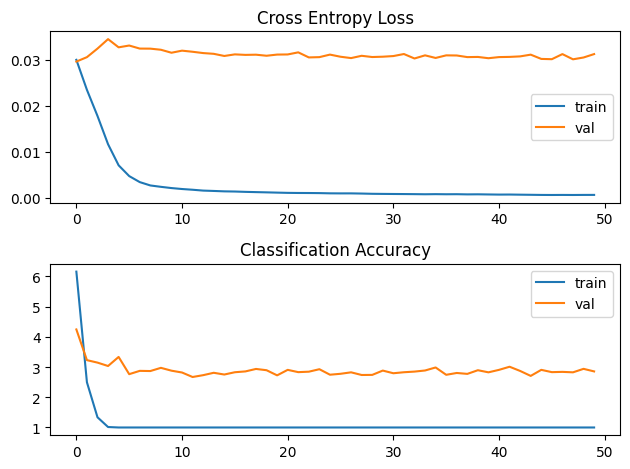

In [13]:
plotTrainingHistory(train_history, val_history)

## Test the model

Evaluate the model in the test set

In [17]:
# Load the best model
# TODO


# Evaluate model on test data
# TODO
def test(dataloader):
    preds = []
    labels = []
    for batch, (X, y) in enumerate(tqdm(dataloader)):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)

        probs = F.softmax(pred, dim=1)
        final_pred = torch.argmax(probs, dim=1)
        preds.extend(final_pred.cpu().numpy())
        #print(final_pred.cpu().numpy())
        original_values =y.cpu().argmax(dim=-1) + 1
        labels.extend(original_values)
        #print(original_values)
    return mean_absolute_error(preds, labels)
test_loss = test(test_dataloader)
print(f"Test loss: {test_loss:.3f}")

100%|██████████| 20/20 [00:44<00:00,  2.22s/it]

Test loss: 2.490


## Challenge

In transfer learning, we often replace the head of the model (fully-connected layers responsible for classification) to fit the task. However, these new layers are not pre-trained and thus they contain an error that is backpropagated through the pre-trained part of the network during training. We can avoid this through a training strategy that is divided into two steps:
* Freeze the pre-trained layers of the network so that their parameters are no longer updated during training and train only the head of the model
* Unfreeze these layers and train the network as a whole.

Implement this strategy and see the results!

## For Group Project - Task 2: Adapt multiclass classification network to regression!

Now that you have a multiclass baseline, adapt the network for the regression problem, considering the following aspects:
* How many neurons should the last layer of a regression network have?
* What should be the final activation function for a regression network?
* What loss functions can be used to train a regression network?